In [6]:
# Load Libraries
import os
import glob
from torchvision.datasets.folder import default_loader
from torchvision.transforms import ToTensor, Compose
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR 
import torch.nn.functional as F
from tqdm import tqdm
import csv
import time
import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [2]:
# Data preprocessing
# Data preprocessing
augment_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel grayscale to 3-channel
    transforms.Resize((224, 224)),                # Resize to fit VGG19 input dimensions
    transforms.ToTensor()
])

root_dir = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/'

def skipping_stride(images_dir, window_size=10, stride=1):
    images = sorted(glob.glob(os.path.join(images_dir, '*.tif')))
    sequences = []
    # if we are predicting LSTM images then should not multiply 
    for start in range(0, len(images), stride * window_size):
        window = images[start: start + stride * window_size:stride]
        sequence = [augment_transforms(default_loader(f)) for f in window]
        sequence_tensor = torch.stack(sequence, dim=0)
        sequences.append(sequence_tensor)
    return sequences

data = []

for subfolder in tqdm(sorted(os.listdir(root_dir)), desc="Processing Subfolders"):
    folder_path = os.path.join(root_dir, subfolder)
    for stride_value in [1,2]:
        sequences = skipping_stride(folder_path, stride=stride_value)
        if sequences:
            data.extend(sequences)


data_tensor = torch.stack(data, dim=0)
print(data_tensor.shape)

# Create the dataset from the tensor
dataset = TensorDataset(data_tensor)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Processing Subfolders: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:16<00:00,  2.00it/s]


torch.Size([1020, 10, 3, 224, 224])


torch.Size([1, 10, 3, 224, 224])


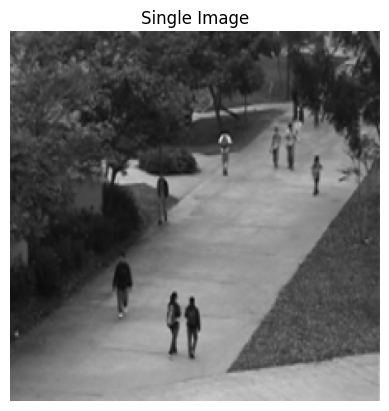

In [3]:
def plot_image_tensor(tensor_image):
    # CxHxW to HxWxC or getting invalid dimensions
    tensor_image = tensor_image.permute(1, 2, 0)  
    plt.imshow(tensor_image.numpy())
    plt.title('Single Image')
    plt.axis('off') 
    plt.show()

# Testing the dataset
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create an iterator from the DataLoader
train_loader_iter = iter(train_loader)

# Fetch the next batch
batch = next(train_loader_iter) 

print(batch[0].shape)

plot_image_tensor(batch[0][0][0])  # Plot the first image from the batch

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models

class ConvLSTMCell(nn.Module):
    """
    Convolutional LSTM Cell
    """
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.gates = nn.Conv2d(in_channels=input_channels + hidden_channels,
                               out_channels=4 * hidden_channels,  # For input, forget, cell, and output gates
                               kernel_size=kernel_size,
                               padding=self.padding)

    def forward(self, input_tensor, hidden_state):
        h_cur, c_cur = hidden_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        #print(f"combined shape: {[input_tensor.shape, h_cur.shape]}")
        gates = self.gates(combined)
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)

        input_gate = torch.sigmoid(input_gate)
        forget_gate = torch.sigmoid(forget_gate)
        cell_gate = torch.tanh(cell_gate)
        output_gate = torch.sigmoid(output_gate)

        c_next = forget_gate * c_cur + input_gate * cell_gate
        h_next = output_gate * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_channels, height, width, device=self.gates.weight.device),
                torch.zeros(batch_size, self.hidden_channels, height, width, device=self.gates.weight.device))

class ConvLSTM_VGG19(nn.Module):
    """
    ConvLSTM model with VGG19-based architecture
    """
    def __init__(self):
        super(ConvLSTM_VGG19, self).__init__()

        # Load pre-trained VGG19 model
        vgg19_features = models.vgg19(pretrained=True).features

        # Using VGG19 as encoder (feature extractor)
        self.encoder = nn.Sequential(*list(vgg19_features.children()))
        
        
        # ConvLSTM layers
        self.convlstm1 = ConvLSTMCell(input_channels=512, hidden_channels=64, kernel_size=3)
        self.convlstm2 = ConvLSTMCell(input_channels=64, hidden_channels=32, kernel_size=3)
        self.convlstm3 = ConvLSTMCell(input_channels=32, hidden_channels=64, kernel_size=3)

        # Spatial Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=10, stride=3, padding=2),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=9, stride=3, padding=2),
            nn.BatchNorm2d(128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=9,stride=3, padding=2)
        )

    def forward(self, x):
        b, seq_len, _, h, w = x.size()
        h1, c1 = self.convlstm1.init_hidden(b, (7, 7))
        h2, c2 = self.convlstm2.init_hidden(b, (7, 7))
        h3, c3 = self.convlstm3.init_hidden(b, (7, 7))

        output_sequence = []
        for t in range(seq_len):
            xt = self.encoder(x[:, t])
            #print("******:" , xt.shape)
            h1, c1 = self.convlstm1(xt, (h1, c1))
            h2, c2 = self.convlstm2(h1, (h2, c2))
            h3, c3 = self.convlstm3(h2, (h3, c3))
            xt = self.decoder(h3)
            xt = torch.sigmoid(xt)
            output_sequence.append(xt.unsqueeze(1))

        output_sequence = torch.cat(output_sequence, dim=1)
        return output_sequence

# Example usage
model = ConvLSTM_VGG19()
image = torch.randn(1, 10, 3, 224, 224)
output = model(image)
print(output.size())


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 10, 3, 224, 224])


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"train_loader.dataset: {len(train_loader.dataset)}")
print(f"val_loader.dataset: {len(val_loader.dataset)}")

model = ConvLSTM_VGG19()  # Assuming ConvLSTM_VGG19 is defined elsewhere
model = nn.DataParallel(model)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, eps=1e-6, weight_decay=1e-5)

# Early stopping parameters
patience = 20
best_val_loss = float('inf')
patience_counter = 0
best_model_path = 'VGG19_ConvLSTM.pth'

# CSV file to store training statistics
csv_file = open('training_statistics.csv', mode='w', newline='')
csv_writer = csv.writer(csv_file, delimiter=',')
csv_writer.writerow(['Epoch', 'Start Time', 'End Time', 'Duration (s)', 'Training Loss', 'Validation Loss'])

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    total_loss = 0.0
    num_batches = 0

    for (images,) in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):
        images = images.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f'Epoch [{epoch + 1}/{num_epochs}] Average Training Loss: {average_loss:.4f}')
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (images,) in val_loader:
            images = images.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, images).item()

    val_loss /= len(val_loader)
    print(f'Validation Loss after Epoch {epoch + 1}: {val_loss:.4f}')

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    # Write statistics to CSV file
    start_time_str = datetime.datetime.fromtimestamp(epoch_start_time).strftime('%Y-%m-%d %H:%M:%S')
    end_time_str = datetime.datetime.fromtimestamp(epoch_end_time).strftime('%Y-%m-%d %H:%M:%S')
    csv_writer.writerow([epoch + 1, start_time_str, end_time_str, epoch_duration, average_loss, val_loss])

    # Early stopping check and model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f'Model saved at epoch {epoch + 1}')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch + 1}')
        break

csv_file.close()

# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

cuda
train_loader.dataset: 816
val_loader.dataset: 204


Epoch 1/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:43<00:00,  1.05s/batch]


Epoch [1/1000] Average Training Loss: 0.0450
Validation Loss after Epoch 1: 0.0136
Model saved at epoch 1


Epoch 2/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:42<00:00,  1.02s/batch]


Epoch [2/1000] Average Training Loss: 0.0173
Validation Loss after Epoch 2: 0.0105
Model saved at epoch 2


Epoch 3/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:42<00:00,  1.04s/batch]


Epoch [3/1000] Average Training Loss: 0.0132
Validation Loss after Epoch 3: 0.0088
Model saved at epoch 3


Epoch 4/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:42<00:00,  1.04s/batch]


Epoch [4/1000] Average Training Loss: 0.0111
Validation Loss after Epoch 4: 0.0084
Model saved at epoch 4


Epoch 5/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:42<00:00,  1.03s/batch]


Epoch [5/1000] Average Training Loss: 0.0098
Validation Loss after Epoch 5: 0.0078
Model saved at epoch 5


Epoch 6/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:41<00:00,  1.02s/batch]


Epoch [6/1000] Average Training Loss: 0.0089
Validation Loss after Epoch 6: 0.0074
Model saved at epoch 6


Epoch 7/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:41<00:00,  1.02s/batch]


Epoch [7/1000] Average Training Loss: 0.0083
Validation Loss after Epoch 7: 0.0070
Model saved at epoch 7


Epoch 8/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:41<00:00,  1.02s/batch]


Epoch [8/1000] Average Training Loss: 0.0077
Validation Loss after Epoch 8: 0.0066
Model saved at epoch 8


Epoch 9/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:42<00:00,  1.03s/batch]


Epoch [9/1000] Average Training Loss: 0.0073
Validation Loss after Epoch 9: 0.0066
Model saved at epoch 9


Epoch 10/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:42<00:00,  1.03s/batch]


Epoch [10/1000] Average Training Loss: 0.0070
Validation Loss after Epoch 10: 0.0063
Model saved at epoch 10


Epoch 11/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.00batch/s]


Epoch [11/1000] Average Training Loss: 0.0068
Validation Loss after Epoch 11: 0.0061
Model saved at epoch 11


Epoch 12/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.02batch/s]


Epoch [12/1000] Average Training Loss: 0.0065
Validation Loss after Epoch 12: 0.0061


Epoch 13/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [13/1000] Average Training Loss: 0.0062
Validation Loss after Epoch 13: 0.0059
Model saved at epoch 13


Epoch 14/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [14/1000] Average Training Loss: 0.0060
Validation Loss after Epoch 14: 0.0058
Model saved at epoch 14


Epoch 15/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [15/1000] Average Training Loss: 0.0058
Validation Loss after Epoch 15: 0.0057
Model saved at epoch 15


Epoch 16/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [16/1000] Average Training Loss: 0.0056
Validation Loss after Epoch 16: 0.0053
Model saved at epoch 16


Epoch 17/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:44<00:00,  1.09s/batch]


Epoch [17/1000] Average Training Loss: 0.0056
Validation Loss after Epoch 17: 0.0072


Epoch 18/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:45<00:00,  1.12s/batch]


Epoch [18/1000] Average Training Loss: 0.0065
Validation Loss after Epoch 18: 0.0059


Epoch 19/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:42<00:00,  1.04s/batch]


Epoch [19/1000] Average Training Loss: 0.0057
Validation Loss after Epoch 19: 0.0054


Epoch 20/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:41<00:00,  1.01s/batch]


Epoch [20/1000] Average Training Loss: 0.0055
Validation Loss after Epoch 20: 0.0053
Model saved at epoch 20


Epoch 21/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:41<00:00,  1.01s/batch]


Epoch [21/1000] Average Training Loss: 0.0053
Validation Loss after Epoch 21: 0.0051
Model saved at epoch 21


Epoch 22/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:41<00:00,  1.01s/batch]


Epoch [22/1000] Average Training Loss: 0.0052
Validation Loss after Epoch 22: 0.0051
Model saved at epoch 22


Epoch 23/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:41<00:00,  1.02s/batch]


Epoch [23/1000] Average Training Loss: 0.0050
Validation Loss after Epoch 23: 0.0051


Epoch 24/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:42<00:00,  1.03s/batch]


Epoch [24/1000] Average Training Loss: 0.0049
Validation Loss after Epoch 24: 0.0049
Model saved at epoch 24


Epoch 25/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:41<00:00,  1.02s/batch]


Epoch [25/1000] Average Training Loss: 0.0048
Validation Loss after Epoch 25: 0.0048
Model saved at epoch 25


Epoch 26/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [26/1000] Average Training Loss: 0.0048
Validation Loss after Epoch 26: 0.0047
Model saved at epoch 26


Epoch 27/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [27/1000] Average Training Loss: 0.0047
Validation Loss after Epoch 27: 0.0047
Model saved at epoch 27


Epoch 28/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [28/1000] Average Training Loss: 0.0046
Validation Loss after Epoch 28: 0.0047


Epoch 29/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [29/1000] Average Training Loss: 0.0046
Validation Loss after Epoch 29: 0.0045
Model saved at epoch 29


Epoch 30/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [30/1000] Average Training Loss: 0.0045
Validation Loss after Epoch 30: 0.0044
Model saved at epoch 30


Epoch 31/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [31/1000] Average Training Loss: 0.0044
Validation Loss after Epoch 31: 0.0044
Model saved at epoch 31


Epoch 32/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [32/1000] Average Training Loss: 0.0043
Validation Loss after Epoch 32: 0.0045


Epoch 33/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [33/1000] Average Training Loss: 0.0043
Validation Loss after Epoch 33: 0.0044
Model saved at epoch 33


Epoch 34/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [34/1000] Average Training Loss: 0.0042
Validation Loss after Epoch 34: 0.0044
Model saved at epoch 34


Epoch 35/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [35/1000] Average Training Loss: 0.0042
Validation Loss after Epoch 35: 0.0044


Epoch 36/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [36/1000] Average Training Loss: 0.0041
Validation Loss after Epoch 36: 0.0041
Model saved at epoch 36


Epoch 37/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [37/1000] Average Training Loss: 0.0041
Validation Loss after Epoch 37: 0.0043


Epoch 38/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [38/1000] Average Training Loss: 0.0041
Validation Loss after Epoch 38: 0.0041


Epoch 39/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.02batch/s]


Epoch [39/1000] Average Training Loss: 0.0040
Validation Loss after Epoch 39: 0.0045


Epoch 40/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [40/1000] Average Training Loss: 0.0040
Validation Loss after Epoch 40: 0.0042


Epoch 41/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [41/1000] Average Training Loss: 0.0039
Validation Loss after Epoch 41: 0.0042


Epoch 42/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [42/1000] Average Training Loss: 0.0039
Validation Loss after Epoch 42: 0.0042


Epoch 43/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [43/1000] Average Training Loss: 0.0038
Validation Loss after Epoch 43: 0.0044


Epoch 44/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [44/1000] Average Training Loss: 0.0038
Validation Loss after Epoch 44: 0.0041
Model saved at epoch 44


Epoch 45/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.02batch/s]


Epoch [45/1000] Average Training Loss: 0.0039
Validation Loss after Epoch 45: 0.0040
Model saved at epoch 45


Epoch 46/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [46/1000] Average Training Loss: 0.0038
Validation Loss after Epoch 46: 0.0039
Model saved at epoch 46


Epoch 47/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:40<00:00,  1.01batch/s]


Epoch [47/1000] Average Training Loss: 0.0037
Validation Loss after Epoch 47: 0.0041


Epoch 48/1000:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38/41 [00:37<00:02,  1.01batch/s]

In [ ]:
# Create an instance of the model
model = ConvLSTM_VGG19()
model = nn.DataParallel(model)
# Load the saved model parameters
model.load_state_dict(torch.load('VGG19_ConvLSTM.pth'))
model.to(device)
# Set the model to evaluation mode if you are using it for inference
model.eval()

from PIL import Image
  
files = [f"Test/Test015/{x:03d}.tif" for x in range(150,200)]

files_iter = iter(files)
 

In [ ]:

# Load one image for testing
image_path = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/' + next(files_iter)
image = Image.open(image_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform =   transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale
    transforms.Resize((224, 224)),                # Resize if necessary
    transforms.ToTensor()                         # Convert to tensor
])
image = transform(image).to(device)
image = image.unsqueeze(1).unsqueeze(1)  # Add a batch dimension at the front 
image = image.permute(1,2, 0, 3, 4)  # Rearranges to [1, 3, 158, 238, 1]
print(image_path)
print(image.shape)
 
with torch.no_grad():
    output = model(image).to(device)
    print("Output shape:", output.shape)

# Convert to NumPy arrays for visualization
np_image = image.squeeze().cpu().numpy()
np_output = output.squeeze().cpu().numpy()

# If the images have channels as the first dimension, transpose them to (H, W, C)
if np_image.shape[0] in (1, 3):
    np_image = np_image.transpose(1, 2, 0)
if np_output.shape[0] in (1, 3):
    np_output = np_output.transpose(1, 2, 0)




# Calculate the absolute difference
difference = np.abs(np_image - np_output) 

# Calculate the MSE
mse = np.mean((np_image - np_output) ** 2)

print("Mean Squared Error:", mse)

# Create a heatmap to visualize the differences
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(np_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np_output, cmap='gray')
plt.title('Output Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(difference, cmap='hot')
plt.title('Difference Heatmap')
plt.axis('off')

plt.show()

